# Noah Márquez & Gemma Vallès

Heart disease prediction using Random Forests

This code is accompanied with several tips including classes, functions and methods to use. Please note that you do not have to follow these tips, but they might be handy in some cases.

Author: Polyxeni Gkontra (polyxeni.gkontra@ub.edu)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt


Read the .csv file with the patient information (TIP: you can use method [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) from pandas) 

In [2]:
df = pd.read_csv('hd_data.csv')

Explore your data. E.g. Print the data or few lines to see how it looks like (TIP: If you want to see just few lines consider method [head()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html#pandas.DataFrame.head) from pandas. Attribute [dtypes](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dtypes.html) and function [describe()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html#pandas.DataFrame.describe) from the same library are useful to check the type of the data in each column and statistical properties, respectively)

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Check statistical details on your data like counts, min, max etc

In [4]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Check the type of the features

In [5]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

Check how many patients you have from each category

In [6]:
# Count the number of patients in each category of 'HeartDisease'
heart_disease_counts = df['HeartDisease'].value_counts()
print(f"With heart disease: {heart_disease_counts[1]} \nNo heart disease: {heart_disease_counts[0]}")

With heart disease: 508 
No heart disease: 410


Split your dataset into training and testing (TIP: You can use [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method from scikit-learn. Please note that good ML practices suggest to always shuffle your data. To this end, for dataframes you can use [sample](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) with the parameter frac as 1, but watch out to add reset_index(drop=True) to reset the index)

In [7]:
# Shuffle the data
data = df.sample(frac=1).reset_index(drop=True)

# Splitting into features and label
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output to check the shapes of the resulting datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((734, 11), (184, 11), (734,), (184,))

Balance the training set (TIP: You can drop patients from the majority class). You can skip this step and use "class_weight" parameter of your classifier to deal with data imbalance

In [8]:
# Concatenate X_train and Y_train
train_data = pd.concat([X_train, y_train], axis=1)

# Delete the subjects from the majority class so that the number of subjects in both classes is the same
label = 'HeartDisease'
healthy = train_data[train_data[label] == 0]
diseased = train_data[train_data[label] == 1]

print('Number of individuals from class 0 before balancing', healthy.shape[0])
print('Number of individuals from class 1 before balancing', diseased.shape[0])

# Delete the ones extra so that the number if equal
if healthy.shape[0] > diseased.shape[0]:
  healthy = healthy.iloc[0:diseased.shape[0],:]
elif healthy.shape[0] < diseased.shape[0]:
  diseased = diseased.iloc[0:healthy.shape[0],:]

print('Number of individuals of class 0 after balancing', healthy.shape[0])
print('Number of individuals of class 1 after balancing', diseased.shape[0])

# Concatenate
df_train = pd.concat([healthy, diseased], axis=0)

# Shuffle the balanced dataset
df_train = df_train.sample(frac=1, random_state=1).reset_index(drop=True)

# Split into X_train and Y_train again
Y_train = df_train[label].copy()
X_train = df_train.drop(label, axis=1)

Number of individuals from class 0 before balancing 333
Number of individuals from class 1 before balancing 401
Number of individuals of class 0 after balancing 333
Number of individuals of class 1 after balancing 333


Data pre-processing 

1.   Encode categorical variables  (TIP: Check [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn-preprocessing-ordinalencoder) from sklearn.preprocessing. Another popular approaches is OneHotEncoder but not appropriate for tree based classifiers, can you imagine why?)
2.   Scale numerical data (TIP: Check [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler))

TIP: 1. It is very important to treat testing and training data separately to avoid data leakage 2. Methods [fit_transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler.fit) (for training data) and [tranfrom](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler.fit) (for the testing data) can be very helpful. Alternatively you can use Pipeline and ColumnTransformer from sklearn but it will be more complicated to retrieve feature names for the most important features

**Answer to the question**

OneHotEncoder, which transforms categorical variables into a format that can be provided to machine learning algorithms, is not typically recommended for tree-based classifiers for a couple of reasons:

    - Sparsity: OneHotEncoder creates a separate binary feature for each category. This can lead to very sparse matrices when there are many categories, which is inefficient for tree-based models.

    - Information Loss: Tree-based models, like Decision Trees and Random Forests, are capable of handling categorical data natively. By converting categories into binary features, important ordinal relationships or hierarchical information among categories might be lost, which could have been utilized effectively by these models.



In [9]:
# Indices of categorical and numerical columns

# Categorical features
cat_feat = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina','ST_Slope']

# Indices of categorical features
categorical_idx = [loc for loc, key in enumerate(X_train.columns) if key in cat_feat]

# Indices of columns with numerical data
numerical_idx = list(set(range(0,X_train.shape[1])) - set(categorical_idx))

# Names of numerical features 
num_feat = X_train.columns[numerical_idx]

# Handle categorical variables
cat_preprocesssor = OrdinalEncoder()
X_train[cat_feat] = cat_preprocesssor.fit_transform(X_train[cat_feat])
X_test[cat_feat] = cat_preprocesssor.transform(X_test[cat_feat])

# Normalize the numerical valyes
num_preprocesssor = MinMaxScaler()
X_train[num_feat] = num_preprocesssor.fit_transform(X_train[num_feat])
X_test[num_feat] = num_preprocesssor.transform(X_test[num_feat])

Train the model (TIP: Check method [fit](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler.fit))

In [10]:
# Random forest classifier with 100 trees, random_state is set to be able to reproduce your results
estimator = RandomForestClassifier(100, max_depth=10, random_state=42)
estimator.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, random_state=42)

Apply the model to the testing data and evaluate its perfromance (TIP: You might use [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn-metrics-classification-report) or [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score))

In [11]:
# Make the prediction
Y_pred = estimator.predict(X_test)

# Evaluate the performance by comparing the predicted labels with the true ones
print(classification_report(y_test,Y_pred))

accuracy = accuracy_score(y_test,Y_pred)
print(f"The accuracy is {accuracy*100}%")

              precision    recall  f1-score   support

           0       0.82      0.91      0.86        77
           1       0.93      0.86      0.89       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.89      0.88      0.88       184

The accuracy is 88.04347826086956%


Get the feature importance in the model's estimation and plot the most important features (TIP: To get feature importance and names you can use feature_importances_ and feature_names_in attributes of your model, respectively)

Text(0.5, 0, "Feature Importance for model's decision")

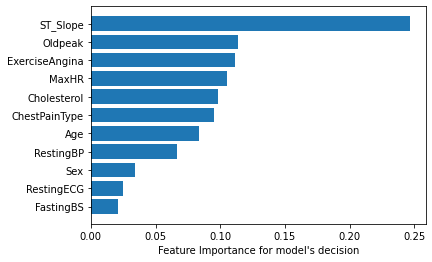

In [12]:
# Sort the features in descending order of importance
sorted_idx = estimator.feature_importances_.argsort()
plt.barh(estimator.feature_names_in_[sorted_idx], estimator.feature_importances_[sorted_idx])
plt.xlabel("Feature Importance for model's decision")

Modify the parameters of the Random Forest (eg maximum depth of the trees and number of trees you use). What do you observe?

In [13]:
# Random forest classifier with 100 trees, random_state is set to be able to reproduce your results
estimator = RandomForestClassifier(500, max_depth=25, random_state=42)
estimator.fit(X_train, Y_train)

RandomForestClassifier(max_depth=25, n_estimators=500, random_state=42)

In [14]:
# Make the prediction
Y_pred = estimator.predict(X_test)

# Evaluate the performance by comparing the predicted labels with the true ones
print(classification_report(y_test,Y_pred))

accuracy = accuracy_score(y_test,Y_pred)
print(f"The accuracy is {accuracy*100}%")

              precision    recall  f1-score   support

           0       0.80      0.90      0.85        77
           1       0.92      0.84      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.87      0.86       184
weighted avg       0.87      0.86      0.86       184

The accuracy is 86.41304347826086%


We can see that increasing the number of max_depth and number of trees in our particular case, makes the accuracy decrease a 0.02.

In [15]:
# Random forest classifier with 100 trees, random_state is set to be able to reproduce your results
estimator = RandomForestClassifier(50, max_depth=5, random_state=42)
estimator.fit(X_train, Y_train)

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=42)

In [16]:
# Make the prediction
Y_pred = estimator.predict(X_test)

# Evaluate the performance by comparing the predicted labels with the true ones
print(classification_report(y_test,Y_pred))

accuracy = accuracy_score(y_test,Y_pred)
print(f"The accuracy is {accuracy*100}%")

              precision    recall  f1-score   support

           0       0.81      0.87      0.84        77
           1       0.90      0.85      0.88       107

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

The accuracy is 85.86956521739131%


We can see that decreasing the number of max_depth and number of trees in our particular case, makes the accuracy also decrease. In conclusion, we found out that deciding the optimal parameters for our Random Forest Classifier is fundamental.